In [246]:

# only run this once if required and margin list has changes from website!!! 
# just run everything else below this cell on regular basis


import time
import tabula
import pandas as pd
import pandas as pd
import datetime
import math
import numpy as np
#import pandas_datareader.data as web
from pandas import Series, DataFrame
from sklearn import preprocessing
import matplotlib.pyplot as plt
from datetime import date, timedelta
import yfinance as yf

pd.set_option('mode.chained_assignment',None)    # turn off chain error warning since I use loc function properly
pd.options.display.float_format = '{:,.2f}'.format




#######################################Create Functionn#############################################


# 1. look at mac
# 2. look at overall market 

def MAC(MACDiff,MACD,Trigger,Movement):
    if MACDiff >= 0.01:
        if MACD < 0 and MACD < Trigger:
            action = 'Buy - accumulate'
        elif MACD < 0 and MACD > Trigger and Movement > 0:
            action = 'Buy - positive trigger'
        elif MACD < 0 and MACD > Trigger and Movement < 0:
            action = 'Buy - weak trigger'
        elif MACD > 0 and MACD > Trigger:
            action = 'Buy - positive signal'
        else:
            action = 'MACD increases but no comment'
    elif MACDiff > -0.01 and MACDiff < 0.01:
        if Movement > 0:
            action = 'MACD flat with buy activity'
        elif Movement < 0:
            action = 'MACD flat with sell activity'
        else:
            action = 'Sideway'
    else:    # MACDIFF IS NEGATIVE
        if MACD > 0:
            action = 'Buy - but momentum declines'    
        elif MACD < 0 and MACD < Trigger:
            action = 'Sell'
        elif MACD < 0 and Movement > 0:                 
            action = 'Sell - a bit of buy support'       #technical bad but ppl still buy? must be good value
        else:
            action = 'MACD declines'
    return action



#######################################download margin#############################################

start = time.time()

myfile = 'https://www.westpac.com.au/content/dam/public/wbc/documents/pdf/pb/1999030/WOIL_Acceptable_Securities_List.pdf'

df2 = tabula.read_pdf(myfile,pages='all')
frames = [df2[0],df2[1],df2[2],df2[3]]
df2 = pd.concat(frames)
df2.drop(['Unnamed: 0','Unnamed: 1','APIR Code','Fund Name','APIR Code Fund Name'],axis=1) 
split1 = df2[['ASX Code','Security Name','LVR']]
split2 = df2[['ASX Code.1','Security Name.1','LVR.1']]
split2.columns=['ASX Code','Security Name','LVR']
df2 = pd.concat([split1,split2])
df2 = df2.dropna()
df2 = df2.drop_duplicates(subset=['ASX Code'])
#df2.loc[:,'ASX Code']=df2['ASX Code'] + '.AX'


a = pd.read_csv('margin.csv')
df = pd.merge(a,df2,on='ASX Code',how='left')
df = df.drop(['LVR_x','Security Name_x'],axis=1)
df = df.rename(columns={'Security Name_y':'Security Name','LVR_y':'LVR'})
df = df[['ASX Code','Security Name','LVR','Industry','Valuation']]
#df = df.style.set_properties(**{'text-align': 'left'})


# drop null lvr values
df.dropna(subset=['LVR'],inplace=True)
df.reset_index(drop=True,inplace=True)


duration = time.time() - start


print (f'The first process to download margin from web took {round(duration,2)} seconds')


#######################################download from YFinance#############################################

# pick up data from yahoo finance
start = datetime.datetime(2020, 7, 1)
end = datetime.date.today() + datetime.timedelta(days=1)
#end = datetime.datetime(2020,10,14)

begin = time.time()

# new code to pick up from csv instead with more details


#mycsv = 'https://raw.githubusercontent.com/RonnyCh/mydsbook/master/margin.csv'
#mystock = pd.read_csv(mycsv)
#mystock = mystock['ASX Code']
#mystock = mystock.replace('^AORD.AX','^AORD')    # all ord does not come with .ax


mystock = df['ASX Code']
# add some missing codes (indexes) such as all ord etc
list = ['^AORD','^DJI','^FTSE','CL=F','^AXJO','^IXIC','^HIS','^N225']
for i, desc in enumerate(list):
      mystock.loc[384+i] = desc




# convert to string to make it better with dowloanding tracker
mystring = ''
mylist = []
for i in mystock:
    if i in ['^AORD','^DJI','^FTSE','CL=F','^AXJO','^IXIC','^HIS','^N225']:     # indexes no need to add .AX
        mystring = mystring + ' ' + i
        mylist.append(i)
    else:
        mystring = mystring + ' ' + i + '.AX'
        mylist.append(i+'.AX')

# download data 
data = yf.download(mystring, start=start, end=end, group_by="ticker")
#data = yf.download(mystring, start=start, end=end)


duration = round(time.time() - begin,2)

print (f'It took {duration} to finish downloading')

###########################tidy up the download data #####################################################

begin = time.time()

# step 1 create a blank table
mycol = ['Code','Close','Volume']
mytbl = pd.DataFrame(columns=mycol)

# step 2 looping through the list and insert to the blank table
for i in mylist:
    df = data[i][['Close','Volume']]     # new one using Yfinance
    df['Code'] = i
    mytbl = mytbl.append(df)

# step 3 tidy up the table
mytbl = mytbl.reset_index()
mytbl = mytbl.rename(columns={'index':'Date'})
mytbl.dropna(subset=['Close'],inplace=True)     # null values for close which happen prob due no data on weekends.
mytbl.set_index('Date',inplace=True)


duration = round(time.time() - begin,2)

print (f'It took {duration} to tidy up the dataframe')
print ('Completed!!!')



The first process to download margin from web took 8.58 seconds
[*********************100%***********************]  392 of 392 completed

1 Failed download:
- ^HIS: No data found, symbol may be delisted
It took 28.57 to finish downloading
It took 2.35 to tidy up the dataframe
Completed!!!


[*********************100%***********************]  8 of 8 completed


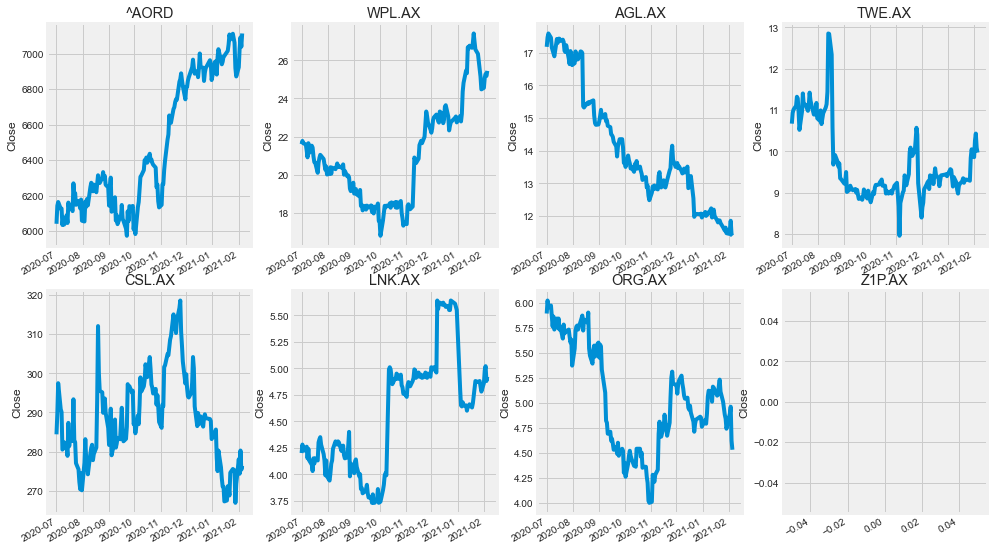

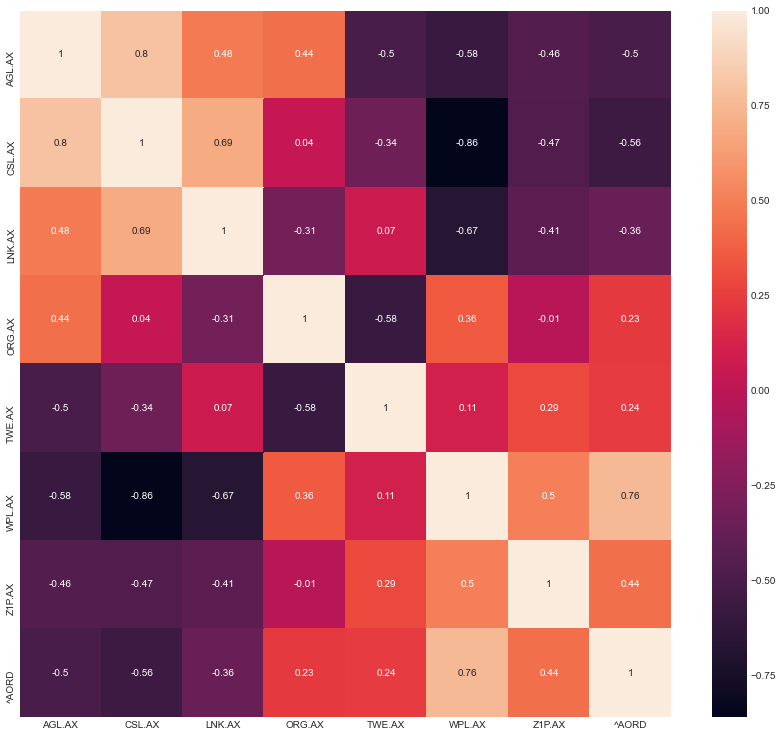

In [242]:
import matplotlib.pyplot as plt
import yfinance as yf
import seaborn as sns
sns.set_style('whitegrid')
plt.style.use("fivethirtyeight")
%matplotlib inline

list = ['^AORD','WPL.AX','AGL.AX','TWE.AX','CSL.AX','LNK.AX','ORG.AX','Z1P.AX']

plt.figure(figsize=(15, 10))
#plt.subplots_adjust(top=1.25, bottom=1.2)

for i, desc in enumerate(list):
    #series = mytbl[mytbl['Code']==list[i]]['Close']    # change the column to vol etc.... 
    #date = mytbl[mytbl['Code']==list[i]]['Date'] 
    plt.subplot(2,4,i+1)
    mytbl[mytbl['Code']==list[i]]['Close'].plot()  
    plt.ylabel('Close')
    plt.xlabel(None)
    plt.title(f"{list[i]}")
    

    
data = yf.download(list, start="2020-12-01", end="2021-02-02")['Close']

corr_table = data.corr().round(2)

plt.figure(figsize=(13, 13))

sns.heatmap(data=corr_table, annot=True)

In [ ]:
import matplotlib.pyplot as plt
import yfinance as yf
import seaborn as sns
sns.set_style('whitegrid')
plt.style.use("fivethirtyeight")
%matplotlib inline

list = ['RIO.AX','IAG.AX','ALD.AX']
x = yf.download(list, start="2021-02-03", end="2021-02-07")['Close']


plt.figure(figsize=(15, 10))
#plt.subplots_adjust(top=1.25, bottom=1.2)

for i, desc in enumerate(list):
    #series = mytbl[mytbl['Code']==list[i]]['Close']    # change the column to vol etc.... 
    #date = mytbl[mytbl['Code']==list[i]]['Date'] 
    plt.subplot(2,4,i+1)
    mytbl[mytbl['Code']==list[i]]['Close'].plot()  
    plt.ylabel('Close')
    plt.xlabel(None)
    plt.title(f"{list[i]}")
    

    

corr_table = data.corr().round(2)

plt.figure(figsize=(13, 13))

sns.heatmap(data=corr_table, annot=True)

[*********************100%***********************]  3 of 3 completed


In [244]:
data

,ALD.AX,IAG.AX,RIO.AX
Date,,,
2021-02-03,26.87,4.97,113.76
2021-02-04,26.64,4.86,114.28
2021-02-05,26.86,4.94,113.33
